In [3]:
# Проверка возможности использования xgbooster в основном, либо предварительно (2017-06-30)

In [4]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skm
from __future__ import print_function

In [5]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [6]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [7]:
sys.path.append('../Python')
from helper import formFH, paths_input

In [463]:
binsData = 75

trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
if True :
    trDirI = trDirJPG
    teDirI = teDirJPG
    ttExt  = '.jpg'
else :
    trDirI = trDirTIF
    teDirI = teDirTIF
    ttExt  = '.tif'
trWork, teWork = '../Work/Train', '../Work/Test'
print (trDirI,teDirI, trWork, teWork)
print (trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG)

../Data/train-jpg ../Data/test-jpg-v2 ../Work/Train ../Work/Test
../Data/train_v2.csv ../Data/train-tif-v2 ../Data/train-jpg ../Data/test-tif-v2 ../Data/test-jpg-v2


In [464]:
xx=os.listdir(trDirI); xx.sort(); xx[:6]

['train_0.jpg',
 'train_1.jpg',
 'train_10.jpg',
 'train_100.jpg',
 'train_1000.jpg',
 'train_10000.jpg']

In [465]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [466]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [467]:
# Add features (0 or 1) for every label as dataframe field 
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
#labels_df.head()

In [468]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [469]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
#labelList[:6,:]
#labels_df.head()

In [470]:
def formImExt (nf, resize=(32,32), printOK=False) :
    nx = None
    try : 
        ni = cv.imread(nf,-1); 
        if (ni is not None) :
            if not ((ni.shape[2]==3) or (ni.shape[2]==4)) and printOK : print('----- error ---- shape:',ni.shape,nf)
            if (ni.shape[2]==3) :
                nx = cv.resize(ni,resize)
            if (ni.shape[2]==4) :
                #r,g,b,n = ni[:,:,2],ni[:,:,1],ni[:,:,0],ni[:,:,3]
                r,g,b,n = cv.resize(ni[:,:,2],resize),cv.resize(ni[:,:,1],resize),cv.resize(ni[:,:,0],resize),cv.resize(ni[:,:,3],resize)
                dv,dw   = np.divide((r-n),(r+n+0.01)), np.divide((g-n),(g+n+0.01))
                nx      = np.array([r,g,b,n,dv,dw]).T; 
    except BaseException as e :
        print(nf,e); nx = None;
    
    if nx is None and printOK : 
        print('------ None:',nf); nx = None
        
    return(nx)

def formImHist (nf, size, printOK=False) :
    
    def hist1 (nf1,bins) :
        h,_ = np.histogram(nf1.ravel(),bins=bins)
        return h.tolist()
    
    def histN (nf,bins) :
        h = []
        for i in range(0,nf.shape[2]) :
            h = h + hist1(nf[:,:,i],bins=bins);
        return h
             
    nx = None
    try : 
        ni = cv.imread(nf,-1);
        if (ni is not None) :
            
            if printOK : print(nf,ni.shape)

            if not ((ni.shape[2]==3) or (ni.shape[2]==4)) and printOK : 
                print('----- error ---- shape:',ni.shape,nf);
            if  ni.shape[2]==3 :
                bins = [x for x in range(0,255+int(round(256.0/size)),int(round(256.0/size)))]
                nx = histN(ni,bins)
            if  ni.shape[2]==4 : 
                bins = [x for x in range(0,65535+int(round(65535.0/size)),int(round(65535.0/size)))]
                r,g,b,n = ni[:,:,2], ni[:,:,1], ni[:,:,0], ni[:,:,3]
                dv,dw   = np.divide((r-n),(r+n+0.01)), np.divide((g-n),(g+n+0.01))
                nx      = np.array([r,g,b,n,dv,dw]).T; 
                nx = histN(ni,bins)
            
    except BaseException as e :
        print(nf,e); nx = None;
    
    if nx is None and printOK : 
        print('------ None:',nf); nx = None
        
    return(nx)

In [471]:
trX, trY, i, size = [],[], 0, len(nameList)
print(datetime.datetime.now(),len(nameList),size)
for nn in nameList[0:size] :
    nf = os.path.join(trDirI,nn+ttExt);
    nx = formImHist(nf,binsData,printOK=False)
    if (nx is not None) :
        #rr=np.save(os.path.join(trWork,nn+".npy"),nx);
        #trX.append(nn+".npy")
        trX.append(nx)
        trY.append(True)
    else : 
        trY.append(False)
    i += 1
    if (i%5000==0) : print(datetime.datetime.now(),"\t",i,"\t",nn)
    #print(nn.shape)

print(datetime.datetime.now())
trX = np.array(trX);
trY = labelList[trY];
print(len(nameList),trX.shape,trY.shape)
#trXY=pd.DataFrame(trY); trXY['name']=trX; trXY.head()
#trXY.to_pickle(os.path.join(trWork,"listFiles.pkl"))

2017-07-02 01:55:01.950992 40479 40479
2017-07-02 01:56:44.791047 	 5000 	 train_4999
2017-07-02 01:58:20.329099 	 10000 	 train_9999
2017-07-02 01:59:51.647616 	 15000 	 train_14999
2017-07-02 02:01:20.559563 	 20000 	 train_19999
2017-07-02 02:02:45.263091 	 25000 	 train_24999
2017-07-02 02:04:03.268459 	 30000 	 train_29999
2017-07-02 02:05:18.466650 	 35000 	 train_34999
2017-07-02 02:06:29.682226 	 40000 	 train_39999
2017-07-02 02:06:36.669877
40479 (40479, 255) (40479, 17)


In [472]:
trX.shape,trY.shape

((40479, 255), (40479, 17))

In [473]:
np.save('../Work/train-data-XX'+str(binsData)+ttExt+'.npy',trX)
np.save('../Work/train-data-YY'+str(binsData)+ttExt+'.npy',trY)

In [474]:
del(trX); del(trY);

In [475]:
trX = np.load('../Work/train-data-XX'+str(binsData)+ttExt+'.npy')
trY = np.load('../Work/train-data-YY'+str(binsData)+ttExt+'.npy')
print(trX.shape,trY.shape)

(40479, 255) (40479, 17)


In [476]:
import xgboost as xgb

In [477]:
# Строим основные массивы
dtrain = xgb.DMatrix(trX,label=trY[:,1])

In [478]:
param = {
         'objective':'reg:logistic', 
         #'num_class':17,
         #'eta':0.05, 
         #'max_depth':9, 'subsample':0.8, 'colsample_bytree':0.8, 
         #'metrics':'rmse'
         'eval_metric':['auc','rmse']
        }
param['silent']=True

results, bstList = [], []
for i in range(trY.shape[1]) :
    print ('Working: {}'.format(i))
    dtrain.set_label(trY[:,i])
    history = xgb.cv(param, dtrain, metrics=['auc'], verbose_eval=30, num_boost_round=1000, nfold=3, early_stopping_rounds=20) #,stratified=True,maximize=True)
    results.append(history)
    rvalidCV = {}
    watchlistCV  = [(dtrain,'train')]
    bst = xgb.train(param, dtrain, history['test-auc-mean'].argmax()+1, watchlistCV) 
    bstList.append(bst)
    

Working: 0
[0]	train-auc:0.948523+0.000546038	test-auc:0.933832+0.00678
[30]	train-auc:0.988173+0.00141962	test-auc:0.959638+0.00215308
[0]	train-auc:0.951655	train-rmse:0.377481
[1]	train-auc:0.957275	train-rmse:0.300147
[2]	train-auc:0.9596	train-rmse:0.250336
[3]	train-auc:0.961825	train-rmse:0.218725
[4]	train-auc:0.963702	train-rmse:0.198916
[5]	train-auc:0.966345	train-rmse:0.187646
[6]	train-auc:0.968926	train-rmse:0.181068
[7]	train-auc:0.969649	train-rmse:0.176983
[8]	train-auc:0.971442	train-rmse:0.174396
[9]	train-auc:0.972018	train-rmse:0.172895
[10]	train-auc:0.973012	train-rmse:0.171047
[11]	train-auc:0.974368	train-rmse:0.170097
[12]	train-auc:0.975208	train-rmse:0.169154
[13]	train-auc:0.976176	train-rmse:0.168202
[14]	train-auc:0.976391	train-rmse:0.167754
[15]	train-auc:0.977798	train-rmse:0.166445
[16]	train-auc:0.978714	train-rmse:0.164622
[17]	train-auc:0.979372	train-rmse:0.164034
[18]	train-auc:0.979922	train-rmse:0.163545
[19]	train-auc:0.980503	train-rmse:0.162

In [479]:
# save xgb models into files
for i in range(len(bstList)) :
    bstList[i].save_model('../Work/Models/model-'+str(100+i)+'-'+str(binsData)+ttExt+'.xgb')

In [480]:
# load xgb models into files
bstNull = xgb.train(param,dtrain,0)
bstList0= []
for i in range(trY.shape[1]) :
    bstList0.append(bstNull.copy())
    bstList0[-1].load_model('../Work/Models/model-'+str(100+i)+'-'+str(binsData)+ttExt+'.xgb')
bstList = bstList0
del bstList0
len(bstList)

17

In [481]:
#[(x['test-rmse-mean'].min(),x['test-rmse-mean'].argmin()) for x in results]

In [482]:
#[(x['test-rmse-mean'].min(),x['test-rmse-mean'].argmin()) for x in results]

In [483]:
#[(x['test-auc-mean'].max(),x['test-auc-mean'].argmax()) for x in results] # 50

In [484]:
#[(x['test-auc-mean'].max(),x['test-auc-mean'].argmax()) for x in results] # 75

In [485]:
#[(x['test-auc-mean'].max(),x['test-auc-mean'].argmax()) for x in results] # 255

In [486]:
#[(x['test-auc-mean'].max(),x['test-auc-mean'].argmax()) for x in results] # 64

In [487]:
trYP = []
for bstI in bstList :
    trYP1 = bstI.predict(dtrain);
    trYP.append(trYP1)
trYP = np.array(trYP).T
type(trYP),trYP.shape

(numpy.ndarray, (40479, 17))

In [488]:
trYPP= trYP.copy() # вероятностный массив
trYP[trYP<0.5] = 0
trYP[trYP!=0]  = 1

In [489]:
#accListOld = accList

In [490]:
accList = []
for i in range(trYP.shape[1]) :
    print ('#{} accuracy={} precision={} recall={} ros_auc={} fbeta2={} not={}'.format(i, 
                                           skm.accuracy_score(trY[:,i],trYP[:,i]), 
                                           skm.precision_score(trY[:,i],trYP[:,i]), 
                                           skm.recall_score(trY[:,i],trYP[:,i]), 
                                           skm.roc_auc_score(trY[:,i],trYP[:,i]), 
                                           skm.fbeta_score(trY[:,i],trYP[:,i],beta=2),
                                           len(trYP[trYP[:,i]<>trY[:,i],i])))
    accList.append((i, skm.roc_auc_score(trY[:,i],trYP[:,i]), skm.confusion_matrix(trY[:,i],trYP[:,i])))
    #fpr,tpr,thr = skm.roc_curve(trY[:,i],trYP[:,i]); print (len(thr),len(fpr),len(trYP[:,i]))
    #plt.plot(fpr,tpr); plt.show()

#0 accuracy=0.96694582376 precision=0.81560613098 recall=0.651093807935 ros_auc=0.820293079395 fbeta2=0.678463797234 not=1338
#1 accuracy=0.988389041231 precision=0.990700755067 recall=0.996827766374 ros_auc=0.939243283052 fbeta2=0.99559630878 not=470
#2 accuracy=0.943081597866 precision=0.921942173143 recall=0.888103938287 ros_auc=0.927612542925 fbeta2=0.894671400291 not=2304
#3 accuracy=0.986388003656 precision=0.987071977638 recall=0.993633709683 ros_auc=0.981461609158 fbeta2=0.992314393301 not=551
#4 accuracy=0.936534993453 precision=0.976762504923 recall=0.66927540143 ros_auc=0.832853498465 fbeta2=0.714244571165 not=2569
#5 accuracy=0.971936065614 precision=0.943117977528 recall=0.733879781421 ros_auc=0.864739939598 fbeta2=0.767955169259 not=1136
#6 accuracy=0.923145334618 precision=0.861832506566 recall=0.731879568827 ros_auc=0.851329194436 fbeta2=0.754637436762 not=3111
#7 accuracy=0.933521085007 precision=0.894434628975 recall=0.452311815948 ros_auc=0.722836647933 fbeta2=0.5019

In [491]:
[(i,cm[0,1]+cm[1,0]-(accList[i][2][1,0]+accListOld[i][2][0,1])) for i,roc,cm in accList]

[(0, 71),
 (1, -221),
 (2, -435),
 (3, -789),
 (4, -513),
 (5, -133),
 (6, 18),
 (7, -53),
 (8, 0),
 (9, -51),
 (10, -497),
 (11, 0),
 (12, -5),
 (13, 0),
 (14, 0),
 (15, 0),
 (16, 0)]

In [492]:
wr = [labels.index(i) for i in weather_labels]; wr
print(labels)
trYPP[trYPP[:,wr].argmax(axis=1)<>trY[:,wr].argmax(axis=1)].shape, wr, (40497.0-2350)/40497.0, (40497.0-1709)/40497.0

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


((848, 17), [3, 10, 0, 9], 0.9419710101982863, 0.9577993431612218)

In [493]:
trY[trYP[10]==1].shape

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 40479 but corresponding boolean dimension is 17
  if __name__ == '__main__':


(3, 17)

In [494]:
# Построение важности полей для разных признаков (importance)
bstga   = np.zeros((trX.shape[1],trY.shape[1]))
for i in range(len(bstList)) :
    bstgfs = bstList[i].get_fscore()
    bstgfs = [(int(n.split('f')[1]),bstgfs[n]) for n in bstgfs.keys()]
    bstga1 = np.array(bstgfs)
    bstga[bstga1[:,0],i] = bstga1[:,1]


if False :
    #bstgfs.sort(key=lambda x: -x[1])
    #bstgfs[:20]
    plt.hist([nn for n,nn in bstgfs],bins=11); plt.show()
    bst_gfs_main = [(n,nn) for n,nn in bstgfs if nn>=20]
    bst_gfs_main.sort(key=lambda x: x[0])
    bst_gfs_main
    bstga[:,6]

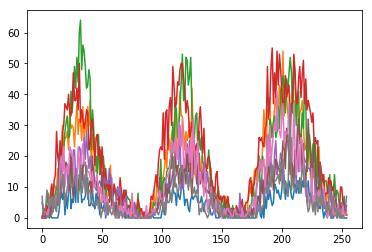

['haze',
 'agriculture',
 'clear',
 'water',
 'habitation',
 'road',
 'cultivation',
 'bare_ground']

In [495]:
xx = [0]+range(2,8)+[12] # плохие 600-4000
plt.plot(bstga[:,xx]); 
#plt.legenda([labels[x] for x in xx])
plt.show();
[labels[x] for x in xx]


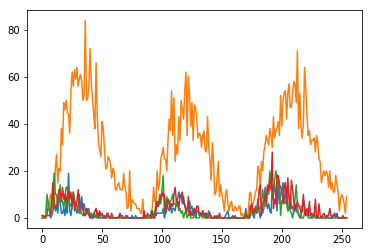

['slash_burn', 'partly_cloudy', 'blooming', 'selective_logging']

In [496]:
xx = [8,10,14,15] # среднии 100-400
plt.plot(bstga[:,xx]); 
#plt.legenda([labels[x] for x in xx])
plt.show();
[labels[x] for x in xx]


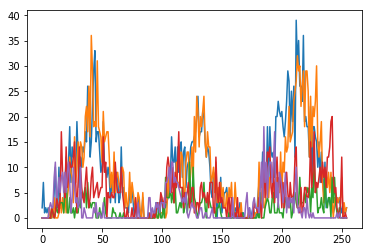

['primary', 'cloudy', 'conventional_mine', 'artisinal_mine', 'blow_down']

In [497]:
xx = [1,9,11,13,16] # отличные 0-100
plt.plot(bstga[:,xx]); plt.show();
[labels[x] for x in xx]

In [498]:
# Попытка посчитать уровень прохождения для каждого признака

In [499]:
ixx,iacc = [], []
for i in range(trY.shape[1]) :
    max, maxxx = 0.0, 0.0
    for xx in range(0,101) :
        tempYP = trYPP[:,i].copy(); #print(tempYP.mean())
        tempYP[tempYP<float(xx/100.0)] = 0
        tempYP[tempYP>0.0]   = 1
        temp = skm.accuracy_score(trY[:,i],tempYP)
        #print(float(xx/10.0),temp)
        if (temp>max) : 
            max = temp; maxxx = float(xx)
            temp = skm.confusion_matrix(trY[:,i],tempYP);
            minloss = temp[0][1]+temp[1][0]
    ixx.append(maxxx)
    tempYP = trYPP[:,i].copy(); #print(tempYP.mean())
    tempYP[tempYP<0.5]   = 0
    tempYP[tempYP>0.0]   = 1
    temp = skm.accuracy_score(trY[:,i],tempYP)
    minloss05 = skm.confusion_matrix(trY[:,i],tempYP);
    minloss05 = minloss05[0][1]+minloss05[1][0]
    iacc.append((maxxx,max,temp,minloss,minloss05))
ixx
#[ixx[xx] for xx in wr]

[42.0,
 56.0,
 45.0,
 53.0,
 35.0,
 39.0,
 42.0,
 37.0,
 13.0,
 43.0,
 47.0,
 14.0,
 22.0,
 27.0,
 22.0,
 20.0,
 14.0]

In [501]:
iacc

[(42.0, 0.96795869463178441, 0.96694582376046834, 1297, 1338),
 (56.0, 0.98927839126460637, 0.98838904123125571, 434, 470),
 (45.0, 0.94325452703871138, 0.9430815978655599, 2297, 2304),
 (53.0, 0.98703031201363667, 0.98638800365621682, 525, 551),
 (35.0, 0.95427258578522201, 0.93653499345339564, 1851, 2569),
 (39.0, 0.97638281578102226, 0.97193606561426915, 956, 1136),
 (42.0, 0.92480051384668593, 0.92314533461795001, 3044, 3111),
 (37.0, 0.94528026878134341, 0.93352108500704067, 2215, 2691),
 (13.0, 0.99836952493885722, 0.99584969984436378, 66, 168),
 (43.0, 0.99673904987771433, 0.99646730403419059, 132, 143),
 (47.0, 0.99960473331851085, 0.99955532498332467, 16, 18),
 (14.0, 0.99982707082684852, 0.99940709997776622, 7, 24),
 (22.0, 0.99053830381185304, 0.98685738284048519, 383, 532),
 (27.0, 1.0, 1.0, 0, 0),
 (22.0, 0.9950097581461993, 0.99335457891746337, 202, 269),
 (20.0, 0.99765310407865804, 0.99439215395637248, 95, 227),
 (14.0, 0.99990118332962774, 0.99898712912868404, 4, 41)]

In [502]:
# Forming output dataset for predicting --> trOX, trOY
del(trX)
del(trY)

In [503]:
nameAsk = os.listdir(teDirI); print(len(nameAsk))
trOX, trOY, i, size = [], [], 0, len(nameAsk)
print(datetime.datetime.now(),len(nameAsk),size)
for nn in nameAsk[0:size] :
    nf = os.path.join(teDirI,nn);
    nx = formImHist(nf,binsData) #,printOK=True)
    if (nx is not None) :
        trOX.append(nx)
        trOY.append(nn)
    i += 1
    if (i%5000==0) : print(datetime.datetime.now(),"\t",i,"\t",nn)

print(datetime.datetime.now())

#assert (size!=len(trOY)), "Wrong files {} != {}".format(size,len(trOY))

61191
2017-07-02 02:35:28.821391 61191 61191
2017-07-02 02:36:01.121810 	 5000 	 test_14523.jpg
2017-07-02 02:36:34.155039 	 10000 	 test_19029.jpg
2017-07-02 02:37:06.829278 	 15000 	 test_23524.jpg
2017-07-02 02:37:39.274162 	 20000 	 test_28015.jpg
2017-07-02 02:38:11.640910 	 25000 	 test_32520.jpg
2017-07-02 02:38:44.041104 	 30000 	 test_37026.jpg
2017-07-02 02:39:16.320961 	 35000 	 test_4908.jpg
2017-07-02 02:39:48.487537 	 40000 	 test_9402.jpg
2017-07-02 02:40:21.039358 	 45000 	 file_13913.jpg
2017-07-02 02:40:53.353753 	 50000 	 file_18419.jpg
2017-07-02 02:41:35.910466 	 55000 	 file_4564.jpg
2017-07-02 02:42:11.694727 	 60000 	 file_892.jpg
2017-07-02 02:42:19.860194


In [504]:
trOX = np.array(trOX);
trOY = np.array([os.path.splitext(x)[0] for x in trOY]);
print(len(nameAsk),trOX.shape,trOY.shape)

61191 (61191, 255) (61191,)


In [505]:
#trOX[20],trOY[20]

In [506]:
# Saving & Loading

In [507]:
np.save('../Work/test-data-XX'+str(binsData)+ttExt+'.npy',trOX)
np.save('../Work/test-data-YY'+str(binsData)+ttExt+'.npy',trOY)

In [508]:
trOX = np.load('../Work/test-data-XX'+str(binsData)+ttExt+'.npy')
trOY = np.load('../Work/test-data-YY'+str(binsData)+ttExt+'.npy')
print(trOX.shape,trOY.shape)

(61191, 255) (61191,)


In [509]:
# Формирование результата
dtest  = xgb.DMatrix(trOX)

In [510]:
trP = []
for bstI in bstList :
    trP1 = bstI.predict(dtest);
    trP.append(trP1)
trP = np.array(trP).T
type(trP),trP.shape    

(numpy.ndarray, (61191, 17))

In [511]:
np.save('../Work/test-data-RR'+str(binsData)+ttExt+'.npy',trP)

In [512]:
trP = np.load('../Work/test-data-RR'+str(binsData)+ttExt+'.npy')
trP.shape

(61191, 17)

In [513]:
wr = [labels.index(i) for i in weather_labels];
trM=np.array(ixx)/100.0 #np.array([0.5]*17);
trM[np.array(wr)] = 2.0
print(wr,'\n',labels,'\n',trM.tolist())

[3, 10, 0, 9] 
 ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down'] 
 [2.0, 0.56, 0.45, 2.0, 0.35, 0.39, 0.42, 0.37, 0.13, 2.0, 2.0, 0.14, 0.22, 0.27, 0.22, 0.2, 0.14]


In [514]:
#trP = model.predict(trX, batch_size=512); trP=K.get_value(trP)
res = []

for i in range(trP.shape[0]) :
    trA1 = [weather_labels[trP[i,wr].argmax()]]
    trA2 = [labels[ii] for ii in range(len(labels)) if (trP[i,ii]>trM[ii])]
    trPP = trA1 + trA2;
    pp   = ' '.join(trPP)
    ##if (pp=="") : print(trY[i])
    res.append([trOY[i],pp])

res.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))
#print(res[4:8],'\n',res[-4:])
print(res[0],'\n',res[-1],'\n',trM,trP[0])

['test_0', 'clear primary'] 
 ['file_20521', 'clear primary'] 
 [ 2.    0.56  0.45  2.    0.35  0.39  0.42  0.37  0.13  2.    2.    0.14
  0.22  0.27  0.22  0.2   0.14] [  1.10700212e-01   2.90093482e-01   2.22463477e-02   2.27843031e-01
   6.58276916e-01   1.19877968e-03   1.15448106e-02   6.40173617e-04
   2.41632879e-04   8.03460598e-01   1.32698828e-04   2.17054214e-04
   6.70437142e-03   1.04527144e-05   2.48264405e-04   4.32673929e-04
   6.35585457e-05]


In [515]:
print(labels)
print(trM.tolist())
#np.round(trP[4:11,:])

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']
[2.0, 0.56, 0.45, 2.0, 0.35, 0.39, 0.42, 0.37, 0.13, 2.0, 2.0, 0.14, 0.22, 0.27, 0.22, 0.2, 0.14]


In [516]:
rrr=pd.DataFrame(res,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-07-02-02-43-05
